# 🧠 04 — EDA Pós-ETL (Exploratory Data Analysis)

Este notebook realiza a **Análise Exploratória de Dados (EDA)** sobre os resultados do pipeline pós-ETL.

Os dados analisados provêm da camada **`data/gold/`**, gerada pelo processo de validação analítica, e incluem:
- `kpi_cost_per_unit.parquet`
- `kpi_energy_per_unit.parquet`
- `kpi_fx_effect.parquet`

📌 **Objetivos:**
1. Avaliar a distribuição e consistência dos KPIs (Key Performance Indicator).
2. Analisar correlações entre custos, energia e variação cambial.
3. Identificar padrões, outliers e tendências temporais por `site_code`.

⚙️ **Camada:** `data/gold/`


## EDA & Modeling — KPIs (Whirlpool)
 -  **Objetivo**: preparar e modelar `cost_per_unit` a partir de `kwh_per_unit` e `fx_effect_ratio`,
 -  com engenharia de atributos, **split temporal**, dois modelos (Elastic Net e Random Forest),
 - **interpretação (SHAP ou permutation importance)** e **cenários**.

### 1) Imports e configuração

In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# SHAP é opcional; se não estiver disponível, usamos permutation importance
try:
    import shap
    _HAS_SHAP = True
except Exception:
    _HAS_SHAP = False

from sklearn.inspection import permutation_importance

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

plt.rcParams.update({"figure.figsize": (8, 4)})

In [4]:
GOLD_DIR = Path('/home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/data/gold')
print('Caminho base:', GOLD_DIR.resolve())

Caminho base: /home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/data/gold


In [5]:
# Etapa 1 — Carregamento dos datasets
p_cost = GOLD_DIR / 'kpi_cost_per_unit.parquet'
p_energy = GOLD_DIR / 'kpi_energy_per_unit.parquet'
p_fx = GOLD_DIR / 'kpi_fx_effect.parquet'

df_cost = pd.read_parquet(p_cost)
df_energy = pd.read_parquet(p_energy)
df_fx = pd.read_parquet(p_fx)

for df in [df_cost, df_energy, df_fx]:
    df['date'] = pd.to_datetime(df['date_key'].astype(str), format='%Y%m%d', errors='coerce')

print('Linhas carregadas:')
print(' - Cost:', len(df_cost))
print(' - Energy:', len(df_energy))
print(' - FX:', len(df_fx))

Linhas carregadas:
 - Cost: 72
 - Energy: 549
 - FX: 72


In [6]:
# Lista todos os arquivos .parquet
parquet_files = sorted(GOLD_DIR.glob("*.parquet"))
print(f"Arquivos encontrados ({len(parquet_files)}):")
for f in parquet_files:
    print(" -", f.name)

Arquivos encontrados (5):
 - kpi_consolidated_features.parquet
 - kpi_cost_per_unit.parquet
 - kpi_energy_per_unit.parquet
 - kpi_fx_effect.parquet
 - qa_report.parquet


In [7]:
# Converte cada parquet para CSV
for parquet_file in parquet_files:
    csv_path = parquet_file.with_suffix(".csv")
    df = pd.read_parquet(parquet_file)
    df.to_csv(csv_path, index=False)
    print(f"Convertido: {parquet_file.name} → {csv_path.name}")

Convertido: kpi_consolidated_features.parquet → kpi_consolidated_features.csv
Convertido: kpi_cost_per_unit.parquet → kpi_cost_per_unit.csv
Convertido: kpi_energy_per_unit.parquet → kpi_energy_per_unit.csv
Convertido: kpi_fx_effect.parquet → kpi_fx_effect.csv
Convertido: qa_report.parquet → qa_report.csv


# 🔧 Imputação Hierárquica

A **imputação hierárquica** é uma técnica para preencher valores ausentes em um conjunto de dados **respeitando a estrutura contextual** das variáveis.  
Em vez de substituir valores faltantes por uma média global (que ignora diferenças entre plantas, períodos ou grupos), esse método considera **níveis sucessivos de agregação**, como:

1. **Site + mês** → comportamento local e sazonal específico  
2. **Site** → tendência média da planta ao longo do tempo  
3. **Mês** → efeito sazonal global  
4. **Global** → tendência geral de toda a amostra

A imputação é feita de forma hierárquica: primeiro tenta preencher no nível mais específico, e se não encontrar valores suficientes, **sobe na hierarquia** até um nível mais agregado.

---

## 🎯 Importância na EDA

Durante a **Análise Exploratória de Dados (EDA)**, dados ausentes podem distorcer estatísticas, gráficos e correlações, pois muitas funções numéricas ignoram valores `NaN`.  
A imputação hierárquica permite:

- **Visualizar séries temporais completas**, sem “buracos” causados por ausências de medição.  
- **Comparar plantas e períodos de forma justa**, já que cada ponto faltante é substituído por um valor representativo dentro do seu contexto.  
- **Preservar coerência estatística**, evitando que um site receba dados de outro site que opere sob condições distintas.

Assim, ela melhora a **qualidade interpretativa da EDA**, mantendo o padrão estrutural e reduzindo viés de amostragem.

---

## 🤖 Importância para a Modelagem com Machine Learning

Modelos de Machine Learning — como regressões, árvores e redes — **não lidam bem com valores nulos**.  
A imputação hierárquica cria uma base contínua e coerente, essencial para:

- **Evitar descarte de observações**, preservando o volume de dados para treino;  
- **Manter a variabilidade real** entre sites e meses, sem misturar padrões diferentes;  
- **Fornecer ao modelo relações mais consistentes** entre as variáveis (ex.: custo, consumo energético e efeito cambial);  
- **Minimizar o risco de overfitting**, pois usa medidas robustas (como a mediana) e não valores extremos.

Em resumo, a imputação hierárquica **reconstrói o conjunto de dados de maneira estatisticamente coerente e interpretável**, servindo como um elo essencial entre a EDA e as etapas seguintes de **engenharia de atributos e modelagem preditiva**.


## 4) Imputação hierárquica do `cost_per_unit`, `kwh_per_unit` e `fx_effect_ratio`.
**Por quê?** Há lacunas relevantes em `cost_per_unit`, `kwh_per_unit` e `fx_effect_ratio`. Para análises e modelos estáveis:
 1. Mediana por (`site_code`, `m`)
 2. Fallback: mediana por `site_code`
 3. Fallback: mediana por `m`
 4. Fallback: mediana global
> Mantemos a coluna original e criamos `cost_per_unit_imp`, `kwh_per_unit_imp` e `fx_effect_ratio`.

In [8]:
# Padronização de chaves de tempo
for df in [df_cost, df_energy, df_fx]:
    df['date_key'] = df['date_key'].astype(int)
    df['y'] = (df['date_key'] // 10000).astype(int)
    df['m'] = ((df['date_key'] // 100) % 100).astype(int)
    df['month_start'] = pd.to_datetime(dict(year=df['y'], month=df['m'], day=1), errors='coerce')

# Merge canônico (outer para checar cobertura)
keys = ['date_key', 'site_code', 'y', 'm']
df = df_cost.merge(df_energy, 
                   on=keys, 
                   how='outer', 
                   suffixes=('_cost','_energy')).merge(df_fx, on=keys, how='outer')

# Imputação hierárquica para cost_per_unit
def impute_cost_energy_fx(d):
    # por site+mês (m), depois site, depois mês, depois global
    d = d.copy()
    cost_by_site_month = d.groupby(['site_code','m'])['cost_per_unit'].transform('median')
    cost_by_site       = d.groupby('site_code')['cost_per_unit'].transform('median')
    cost_by_month      = d.groupby('m')['cost_per_unit'].transform('median')
    cost_global_med    = d['cost_per_unit'].median()
    d['cost_per_unit_imp'] = d['cost_per_unit'].fillna(cost_by_site_month).fillna(cost_by_site).fillna(cost_by_month).fillna(cost_global_med)

    kwh_by_site_month = d.groupby(['site_code','m'])['kwh_per_unit'].transform('median')
    kwh_by_site       = d.groupby('site_code')['kwh_per_unit'].transform('median')
    kwh_by_month      = d.groupby('m')['kwh_per_unit'].transform('median')
    kwh_global_med    = d['kwh_per_unit'].median()
    d['kwh_per_unit_imp'] = d['kwh_per_unit'].fillna(kwh_by_site_month).fillna(kwh_by_site).fillna(kwh_by_month).fillna(kwh_global_med)

    fx_by_site_month = d.groupby(['site_code','m'])['fx_effect_ratio'].transform('median')
    fx_by_site       = d.groupby('site_code')['fx_effect_ratio'].transform('median')
    fx_by_month      = d.groupby('m')['fx_effect_ratio'].transform('median')
    fx_global_med    = d['fx_effect_ratio'].median()
    d['fx_effect_ratio_imp'] = d['fx_effect_ratio'].fillna(fx_by_site_month).fillna(fx_by_site).fillna(fx_by_month).fillna(fx_global_med)
    
    return d
    
df = impute_cost_energy_fx(df)

### Verificação da coerência pós-imputação.

In [9]:
df[['cost_per_unit','cost_per_unit_imp', 'kwh_per_unit', 'kwh_per_unit_imp', 'fx_effect_ratio', 'fx_effect_ratio_imp']].describe()

,cost_per_unit,cost_per_unit_imp,kwh_per_unit,kwh_per_unit_imp,fx_effect_ratio,fx_effect_ratio_imp
count,18.000000,603.000000,549.000000,603.000000,7.200000e+01,6.030000e+02
mean,776.663627,773.241506,0.520155,0.521197,-1.442642e-07,1.739065e-06
std,131.801404,124.345485,0.036337,0.034854,4.937641e-06,3.522116e-06
min,632.878899,632.878899,0.417623,0.417623,-1.072773e-05,-1.072773e-05
25%,709.734483,709.616960,0.500777,0.504568,-3.313568e-06,6.709310e-07
50%,726.547613,724.401227,0.532348,0.532897,1.445335e-07,1.797002e-06
75%,781.169351,781.678633,0.545316,0.543633,3.670557e-06,3.761446e-06
max,1110.296310,1110.296310,0.610069,0.610069,8.031652e-06,8.031652e-06


### Normalizar o fx_effect_ratio.

In [10]:
df.duplicated(['date_key', 'site_code']).sum()

np.int64(0)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_key             603 non-null    int64         
 1   y                    603 non-null    int64         
 2   m                    603 non-null    int64         
 3   site_code            603 non-null    object        
 4   cost_per_unit        18 non-null     float64       
 5   date_cost            72 non-null     datetime64[ns]
 6   month_start_cost     72 non-null     datetime64[ns]
 7   kwh_per_unit         549 non-null    float64       
 8   date_energy          549 non-null    datetime64[ns]
 9   month_start_energy   549 non-null    datetime64[ns]
 10  fx_effect_ratio      72 non-null     float64       
 11  date                 72 non-null     datetime64[ns]
 12  month_start          72 non-null     datetime64[ns]
 13  cost_per_unit_imp    603 non-null  

In [12]:
def dq_summary(df, kpi_col):
    n = len(df)
    out = {
        "rows": n,
        "sites": df["site_code"].nunique(),
        "start": df["month_start"].min(),
        "end": df["month_start"].max(),
        "nulls": int(df[kpi_col].isna().sum()),
        "null_%": round(100 * df[kpi_col].isna().mean(), 2),
        "negs": int((df[kpi_col] < 0).sum()) if pd.api.types.is_numeric_dtype(df[kpi_col]) else None,
        "zeros": int((df[kpi_col] == 0).sum()) if pd.api.types.is_numeric_dtype(df[kpi_col]) else None,
        "dup_keys": int(df.duplicated(["date_key", "site_code"]).sum()),
    }
    return out

In [13]:
print("DQ cost:", dq_summary(df, "cost_per_unit"))
print("DQ kwh :", dq_summary(df, "kwh_per_unit"))
print("DQ fx  :", dq_summary(df, "fx_effect_ratio"))

DQ cost: {'rows': 603, 'sites': 3, 'start': Timestamp('2024-01-01 00:00:00'), 'end': Timestamp('2025-12-01 00:00:00'), 'nulls': 585, 'null_%': np.float64(97.01), 'negs': 0, 'zeros': 0, 'dup_keys': 0}
DQ kwh : {'rows': 603, 'sites': 3, 'start': Timestamp('2024-01-01 00:00:00'), 'end': Timestamp('2025-12-01 00:00:00'), 'nulls': 54, 'null_%': np.float64(8.96), 'negs': 0, 'zeros': 0, 'dup_keys': 0}
DQ fx  : {'rows': 603, 'sites': 3, 'start': Timestamp('2024-01-01 00:00:00'), 'end': Timestamp('2025-12-01 00:00:00'), 'nulls': 531, 'null_%': np.float64(88.06), 'negs': 33, 'zeros': 0, 'dup_keys': 0}


## 5) Feature engineering
Criação de atributos para melhorar a capacidade preditiva e explicativa:
- **Dummies**: `site_code` e `m` (sazonalidade mensal).
- **Lags** (se houver histórico): `kwh_per_unit_t-1`, `fx_effect_ratio_t-1`, `cost_per_unit_imp_t-1` por site.
- **Rolling means**: médias móveis de 3 meses por site (quando possível).

In [14]:
df = df.sort_values(["site_code", "month_start"]).copy()

def add_lag_roll(d, col, group="site_code"):
    d = d.copy()
    d[f"{col}_lag1"]  = d.groupby(group)[col].shift(1)
    d[f"{col}_roll3"] = (
        d.groupby(group)[col].rolling(3, min_periods=2).mean().reset_index(level=0, drop=True)
    )
    return d

In [15]:
for col in ["cost_per_unit_imp", "kwh_per_unit_imp", "fx_effect_ratio_imp"]:
    df = add_lag_roll(df, col)

TARGET = "cost_per_unit_imp"
BASE_FEATURES = [
    "kwh_per_unit_imp", "fx_effect_ratio_imp",
    "cost_per_unit_imp_lag1", "kwh_per_unit_imp_lag1", "fx_effect_ratio_imp_lag1",
    "cost_per_unit_imp_roll3", "kwh_per_unit_imp_roll3", "fx_effect_ratio_imp_roll3",
    "m", "site_code"
]

In [16]:
model_df = df.dropna(subset=[TARGET, "m"]).copy()
print(model_df[BASE_FEATURES + [TARGET]].head())

    kwh_per_unit_imp  fx_effect_ratio_imp  cost_per_unit_imp_lag1  \
0           0.526513        -3.708762e-08                     NaN   
3           0.526513         1.029906e-07              777.922403   
6           0.526513        -5.269614e-06              777.922403   
9           0.521236         8.005353e-06              777.922403   
12          0.525543         1.157692e-06              800.112631   

    kwh_per_unit_imp_lag1  fx_effect_ratio_imp_lag1  cost_per_unit_imp_roll3  \
0                     NaN                       NaN                      NaN   
3                0.526513             -3.708762e-08               777.922403   
6                0.526513              1.029906e-07               777.922403   
9                0.526513             -5.269614e-06               785.319145   
12               0.521236              8.005353e-06               758.418232   

    kwh_per_unit_imp_roll3  fx_effect_ratio_imp_roll3  m site_code  \
0                      NaN        

### Drop das colunas desnecessárias.

In [17]:
drop_cols = [
    'cost_per_unit', 'date_cost', 'month_start_cost',
    'kwh_per_unit', 'date_energy', 'month_start_energy',
    'fx_effect_ratio', 'date', 'month_start'
]

model_df = model_df.drop(columns=drop_cols, errors='ignore')

## 2️⃣ Análise descritiva geral
Nesta etapa, calculamos estatísticas descritivas básicas para entender as escalas, dispersões e possíveis outliers de cada KPI.

In [ ]:
display(model_df.info())

In [ ]:
# Etapa 2 — Estatísticas descritivas
display(model_df.describe())

## 3️⃣ Séries temporais e variações por site
Visualizamos as tendências dos KPIs ao longo do tempo para cada `site_code`.

In [ ]:
# Etapa 3 — Séries temporais
sites = sorted(model_df['site_code'].dropna().unique())
for site in sites:
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'Séries temporais — {site}', fontsize=14)

    sns.lineplot(data=model_df[model_df['site_code']==site], x='m', y='cost_per_unit_imp', ax=axs[0], color='royalblue')
    sns.lineplot(data=model_df[model_df['site_code']==site], x='m', y='kwh_per_unit_imp', ax=axs[1], color='orange')
    sns.lineplot(data=model_df[model_df['site_code']==site], x='m', y='fx_effect_ratio_imp', ax=axs[2], color='green')

    axs[0].set_ylabel('Cost per Unit')
    axs[1].set_ylabel('kWh per Unit')
    axs[2].set_ylabel('FX Effect')
    axs[2].set_xlabel('Data (mounth)')
    plt.tight_layout()
    plt.show()

In [ ]:
# Etapa 3 — Séries temporais
sites = sorted(model_df['site_code'].dropna().unique())
for site in sites:
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'Séries temporais com Lag1— {site}', fontsize=14)

    sns.lineplot(data=model_df[model_df['site_code']==site], x='m', y='cost_per_unit_imp_lag1', ax=axs[0], color='royalblue')
    sns.lineplot(data=model_df[model_df['site_code']==site], x='m', y='kwh_per_unit_imp_lag1', ax=axs[1], color='orange')
    sns.lineplot(data=model_df[model_df['site_code']==site], x='m', y='fx_effect_ratio_imp_lag1', ax=axs[2], color='green')

    axs[0].set_ylabel('Cost per Unit_lag1')
    axs[1].set_ylabel('kWh per Unit_lag1')
    axs[2].set_ylabel('FX Effect_lag1')
    axs[2].set_xlabel('Data (mounth)')
    plt.tight_layout()
    plt.show()

In [ ]:
sites = sorted(model_df['site_code'].dropna().unique())
for site in sites:
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'Séries temporais com médias móveis (3m) — {site}', fontsize=14)

    sns.lineplot(data=model_df[model_df['site_code']==site], x='m', y='cost_per_unit_imp_roll3', ax=axs[0], color='royalblue')
    sns.lineplot(data=model_df[model_df['site_code']==site], x='m', y='kwh_per_unit_imp_roll3', ax=axs[1], color='orange')
    sns.lineplot(data=model_df[model_df['site_code']==site], x='m', y='fx_effect_ratio_imp_roll3', ax=axs[2], color='green')

    axs[0].set_ylabel('Cost per Unit')
    axs[1].set_ylabel('kWh per Unit')
    axs[2].set_ylabel('FX Effect')
    axs[2].set_xlabel('Data (mounth)')
    plt.tight_layout()
    plt.show()

## 4️⃣ Correlação entre KPIs
Verificamos se há correlação entre custos, consumo energético e variação cambial.

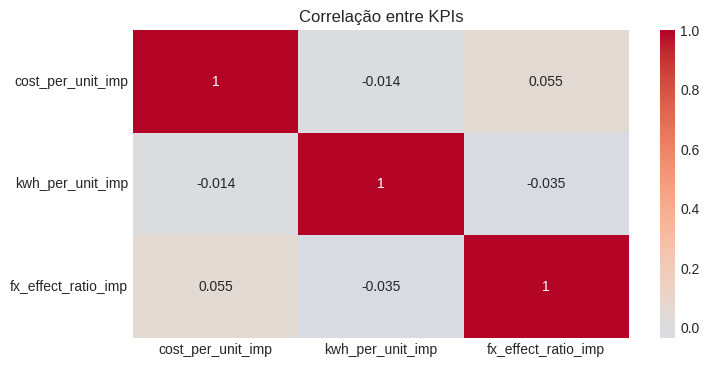

In [18]:
# Etapa 4 — Correlação entre KPIs
corr = model_df[['cost_per_unit_imp', 'kwh_per_unit_imp', 'fx_effect_ratio_imp']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre KPIs')
plt.show()

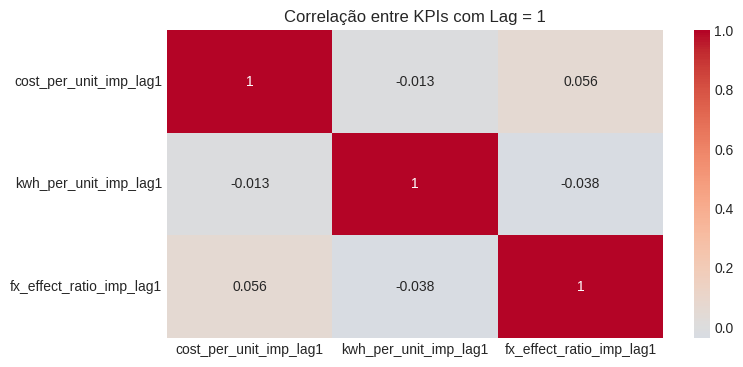

In [19]:
# Etapa 4 — Correlação entre KPIs
corr = model_df[['cost_per_unit_imp_lag1', 'kwh_per_unit_imp_lag1', 'fx_effect_ratio_imp_lag1']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre KPIs com Lag = 1')
plt.show()

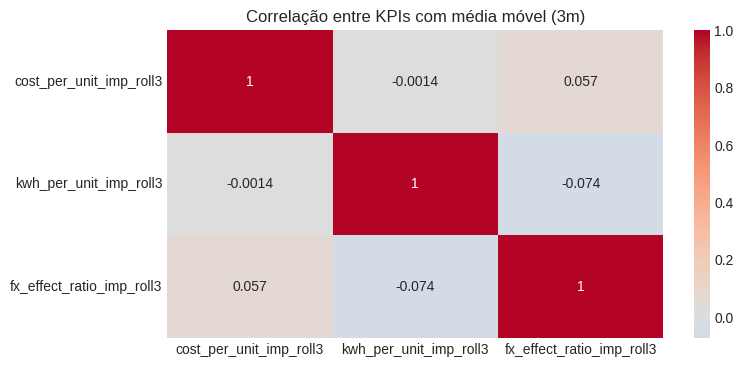

In [20]:
# Etapa 4 — Correlação entre KPIs
corr = model_df[['cost_per_unit_imp_roll3', 'kwh_per_unit_imp_roll3', 'fx_effect_ratio_imp_roll3']].corr()
sns.heatmap(data=corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre KPIs com média móvel (3m)')
plt.show()

## 5️⃣ Detecção de outliers e anomalias
Identificamos valores fora das faixas esperadas em cada KPI.

In [21]:
# Etapa 5 — Outliers (3 desvios padrão)
for name, df, col in [
    ('Cost per Unit_imp', model_df, 'cost_per_unit_imp'),
    ('kWh per Unit', model_df, 'kwh_per_unit_imp'),
    ('Efeito cambial', model_df, 'fx_effect_ratio_imp')
]:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[(df[col] < mean - 3*std) | (df[col] > mean + 3*std)]
    print(f'{name}: {len(outliers)} outliers detectados.')

Cost per Unit_imp: 0 outliers detectados.
kWh per Unit: 0 outliers detectados.
Efeito cambial: 6 outliers detectados.


In [24]:
# =========================
# 5.1) Detecção + Investigação
# =========================
import numpy as np
import pandas as pd

CHECK_COLS = ["cost_per_unit_imp", "kwh_per_unit_imp", "fx_effect_ratio_imp"]

def flag_outliers_3sigma(df, col, by=None):
    """
    Marca outliers por regra de 3*std.
    Se 'by' é fornecido (ex.: ['site_code','m']), calcula média e std por grupo.
    Retorna df com colunas auxiliares: <col>_z e <col>_is_outlier.
    """
    d = df.copy()
    if by:
        stats = d.groupby(by)[col].agg(['mean','std']).rename(columns={'mean':f'{col}_mean', 'std':f'{col}_std'})
        d = d.merge(stats, on=by, how='left')
        z = (d[col] - d[f'{col}_mean']) / d[f'{col}_std']
    else:
        z = (d[col] - d[col].mean()) / d[col].std()
    d[f'{col}_z'] = z
    d[f'{col}_is_outlier'] = z.abs() > 3
    return d

# Marcar outliers por site+mês (mais informativo para operação)
by_keys = ['site_code','m']
mdf = model_df.copy()
for c in CHECK_COLS:
    mdf = flag_outliers_3sigma(mdf, c, by=by_keys)

# Relatório de investigação: contagem por KPI, site e mês
outlier_long = []
for c in CHECK_COLS:
    tmp = (
        mdf.loc[mdf[f'{c}_is_outlier'], ['site_code','m', c, f'{c}_z']]
        .assign(kpi=c)
        .rename(columns={c: 'value', f'{c}_z':'z'})
    )
    outlier_long.append(tmp)
outlier_long = pd.concat(outlier_long, ignore_index=True)

report_counts = (outlier_long
                 .groupby(['kpi','site_code','m'])
                 .size()
                 .reset_index(name='n_outliers')
                 .sort_values(['kpi','n_outliers'], ascending=[True, False]))

print("=== Resumo de outliers por KPI/site/mês ===")
print(report_counts.head(20))

print("\n=== Amostras de linhas anômalas (para auditoria) ===")
print(outlier_long.sort_values('z', key=np.abs, ascending=False).head(10))

# (Opcional) salvar o relatório para inspeção externa
report_counts.to_csv("/home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/data/gold/outliers_report_counts.csv", index=False)
outlier_long.to_csv("/home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/data/gold/outliers_samples.csv", index=False)

# =========================
# 5.2) Tratamento Orientado
# =========================
# Escolha UMA das estratégias abaixo (ou combine), versão por KPI.

# --- Opção A: Winsorização (capping) por grupo -----------------
def winsorize_by_group(df, col, by, lower=0.01, upper=0.99):
    """
    Aplica winsorização por quantis dentro de cada grupo (site_code, m ou apenas site_code).
    Mantém a distribuição, mas corta caudas extremas.
    """
    d = df.copy()
    def _cap(group):
        lo = group[col].quantile(lower)
        hi = group[col].quantile(upper)
        return group.assign(**{f'{col}_cap': group[col].clip(lower=lo, upper=hi)})
    return d.groupby(by, group_keys=False).apply(_cap)

# Exemplo: winsorizar FX por site (mais estável que por mês)
mdf_w = winsorize_by_group(mdf, 'fx_effect_ratio_imp', by=['site_code'], lower=0.01, upper=0.99)

# --- Opção B: Escalonamento Robusto para modelagem ----------------
from sklearn.preprocessing import RobustScaler

def add_robust_scaled(df, col, by=None):
    """
    Cria <col>_robust usando mediana e IQR (RobustScaler).
    Se 'by' é fornecido, ajusta um scaler por grupo.
    """
    d = df.copy()
    if by:
        def _scale(group):
            scaler = RobustScaler()
            vals = scaler.fit_transform(group[[col]])
            group[f'{col}_robust'] = vals.astype(float)
            return group
        d = d.groupby(by, group_keys=False).apply(_scale)
    else:
        scaler = RobustScaler()
        d[f'{col}_robust'] = scaler.fit_transform(d[[col]]).astype(float)
    return d

# Exemplo: gerar versão robusta das 3 KPIs por site (bom para modelos lineares)
for c in CHECK_COLS:
    mdf_w = add_robust_scaled(mdf_w, c, by=['site_code'])

# =========================
# 5.3) Saída para os próximos passos
# =========================
# Mantemos colunas originais + *_cap + *_robust para comparar no treino
cols_export = sorted({*mdf_w.columns})  # exporta tudo; ajuste se quiser
mdf_w.to_parquet("/home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/data/gold/kpi_consolidated_outliers_treated.parquet", index=False)
print("Arquivo com tratamentos salvo em data/gold/kpi_consolidated_outliers_treated.parquet")

=== Resumo de outliers por KPI/site/mês ===
                    kpi site_code  m  n_outliers
0   fx_effect_ratio_imp      SC01  4           2
1   fx_effect_ratio_imp      SC01  5           2
2   fx_effect_ratio_imp      SC01  6           2
3   fx_effect_ratio_imp      SC01  7           2
4   fx_effect_ratio_imp      SC01  8           2
5   fx_effect_ratio_imp      SC01  9           2
6   fx_effect_ratio_imp      SC02  4           2
7   fx_effect_ratio_imp      SC02  5           2
8   fx_effect_ratio_imp      SC02  6           2
9   fx_effect_ratio_imp      SC02  7           2
10  fx_effect_ratio_imp      SC02  8           2
11  fx_effect_ratio_imp      SC02  9           2
12  fx_effect_ratio_imp      SC03  4           2
13  fx_effect_ratio_imp      SC03  5           2
14  fx_effect_ratio_imp      SC03  6           2
15  fx_effect_ratio_imp      SC03  7           2
16  fx_effect_ratio_imp      SC03  8           2
17  fx_effect_ratio_imp      SC03  9           2

=== Amostras de linhas a

/tmp/ipykernel_6402/2519541933.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return d.groupby(by, group_keys=False).apply(_cap)
/tmp/ipykernel_6402/2519541933.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d = d.groupby(by, group_keys=False).apply(_scale)
/tmp/ipykernel_6402/2519541933.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecate

Arquivo com tratamentos salvo em data/gold/kpi_consolidated_outliers_treated.parquet


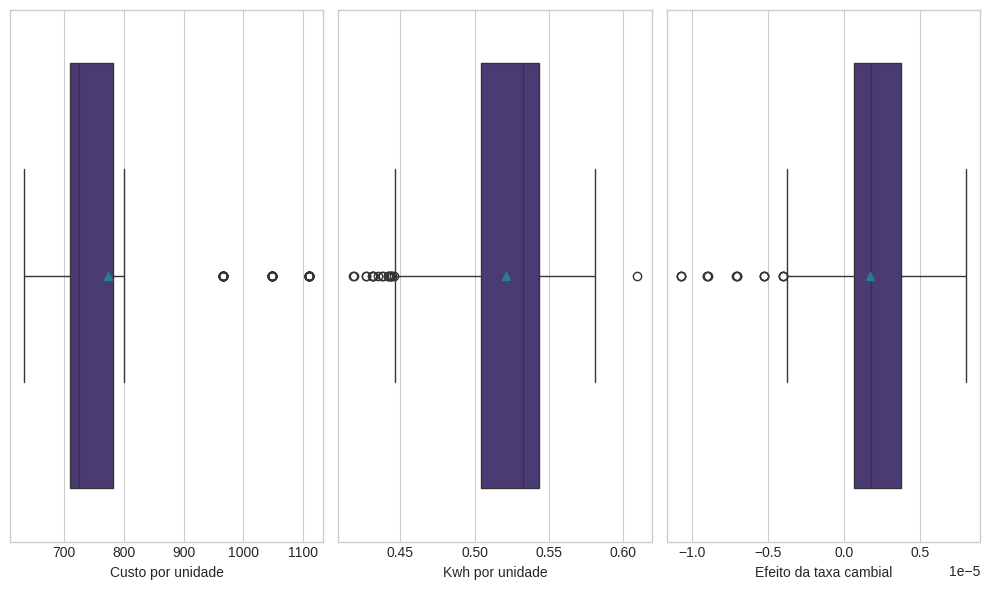

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharex=False)

sns.boxplot(x = model_df['cost_per_unit_imp'], ax=axs[0], showmeans = True)
sns.boxplot(x = model_df['kwh_per_unit_imp'], ax=axs[1], showmeans = True)
sns.boxplot(x = model_df['fx_effect_ratio_imp'], ax=axs[2], showmeans = True)

axs[0].set_xlabel('Custo por unidade')
axs[1].set_xlabel('Kwh por unidade')
axs[2].set_xlabel('Efeito da taxa cambial')

plt.tight_layout()
plt.show()

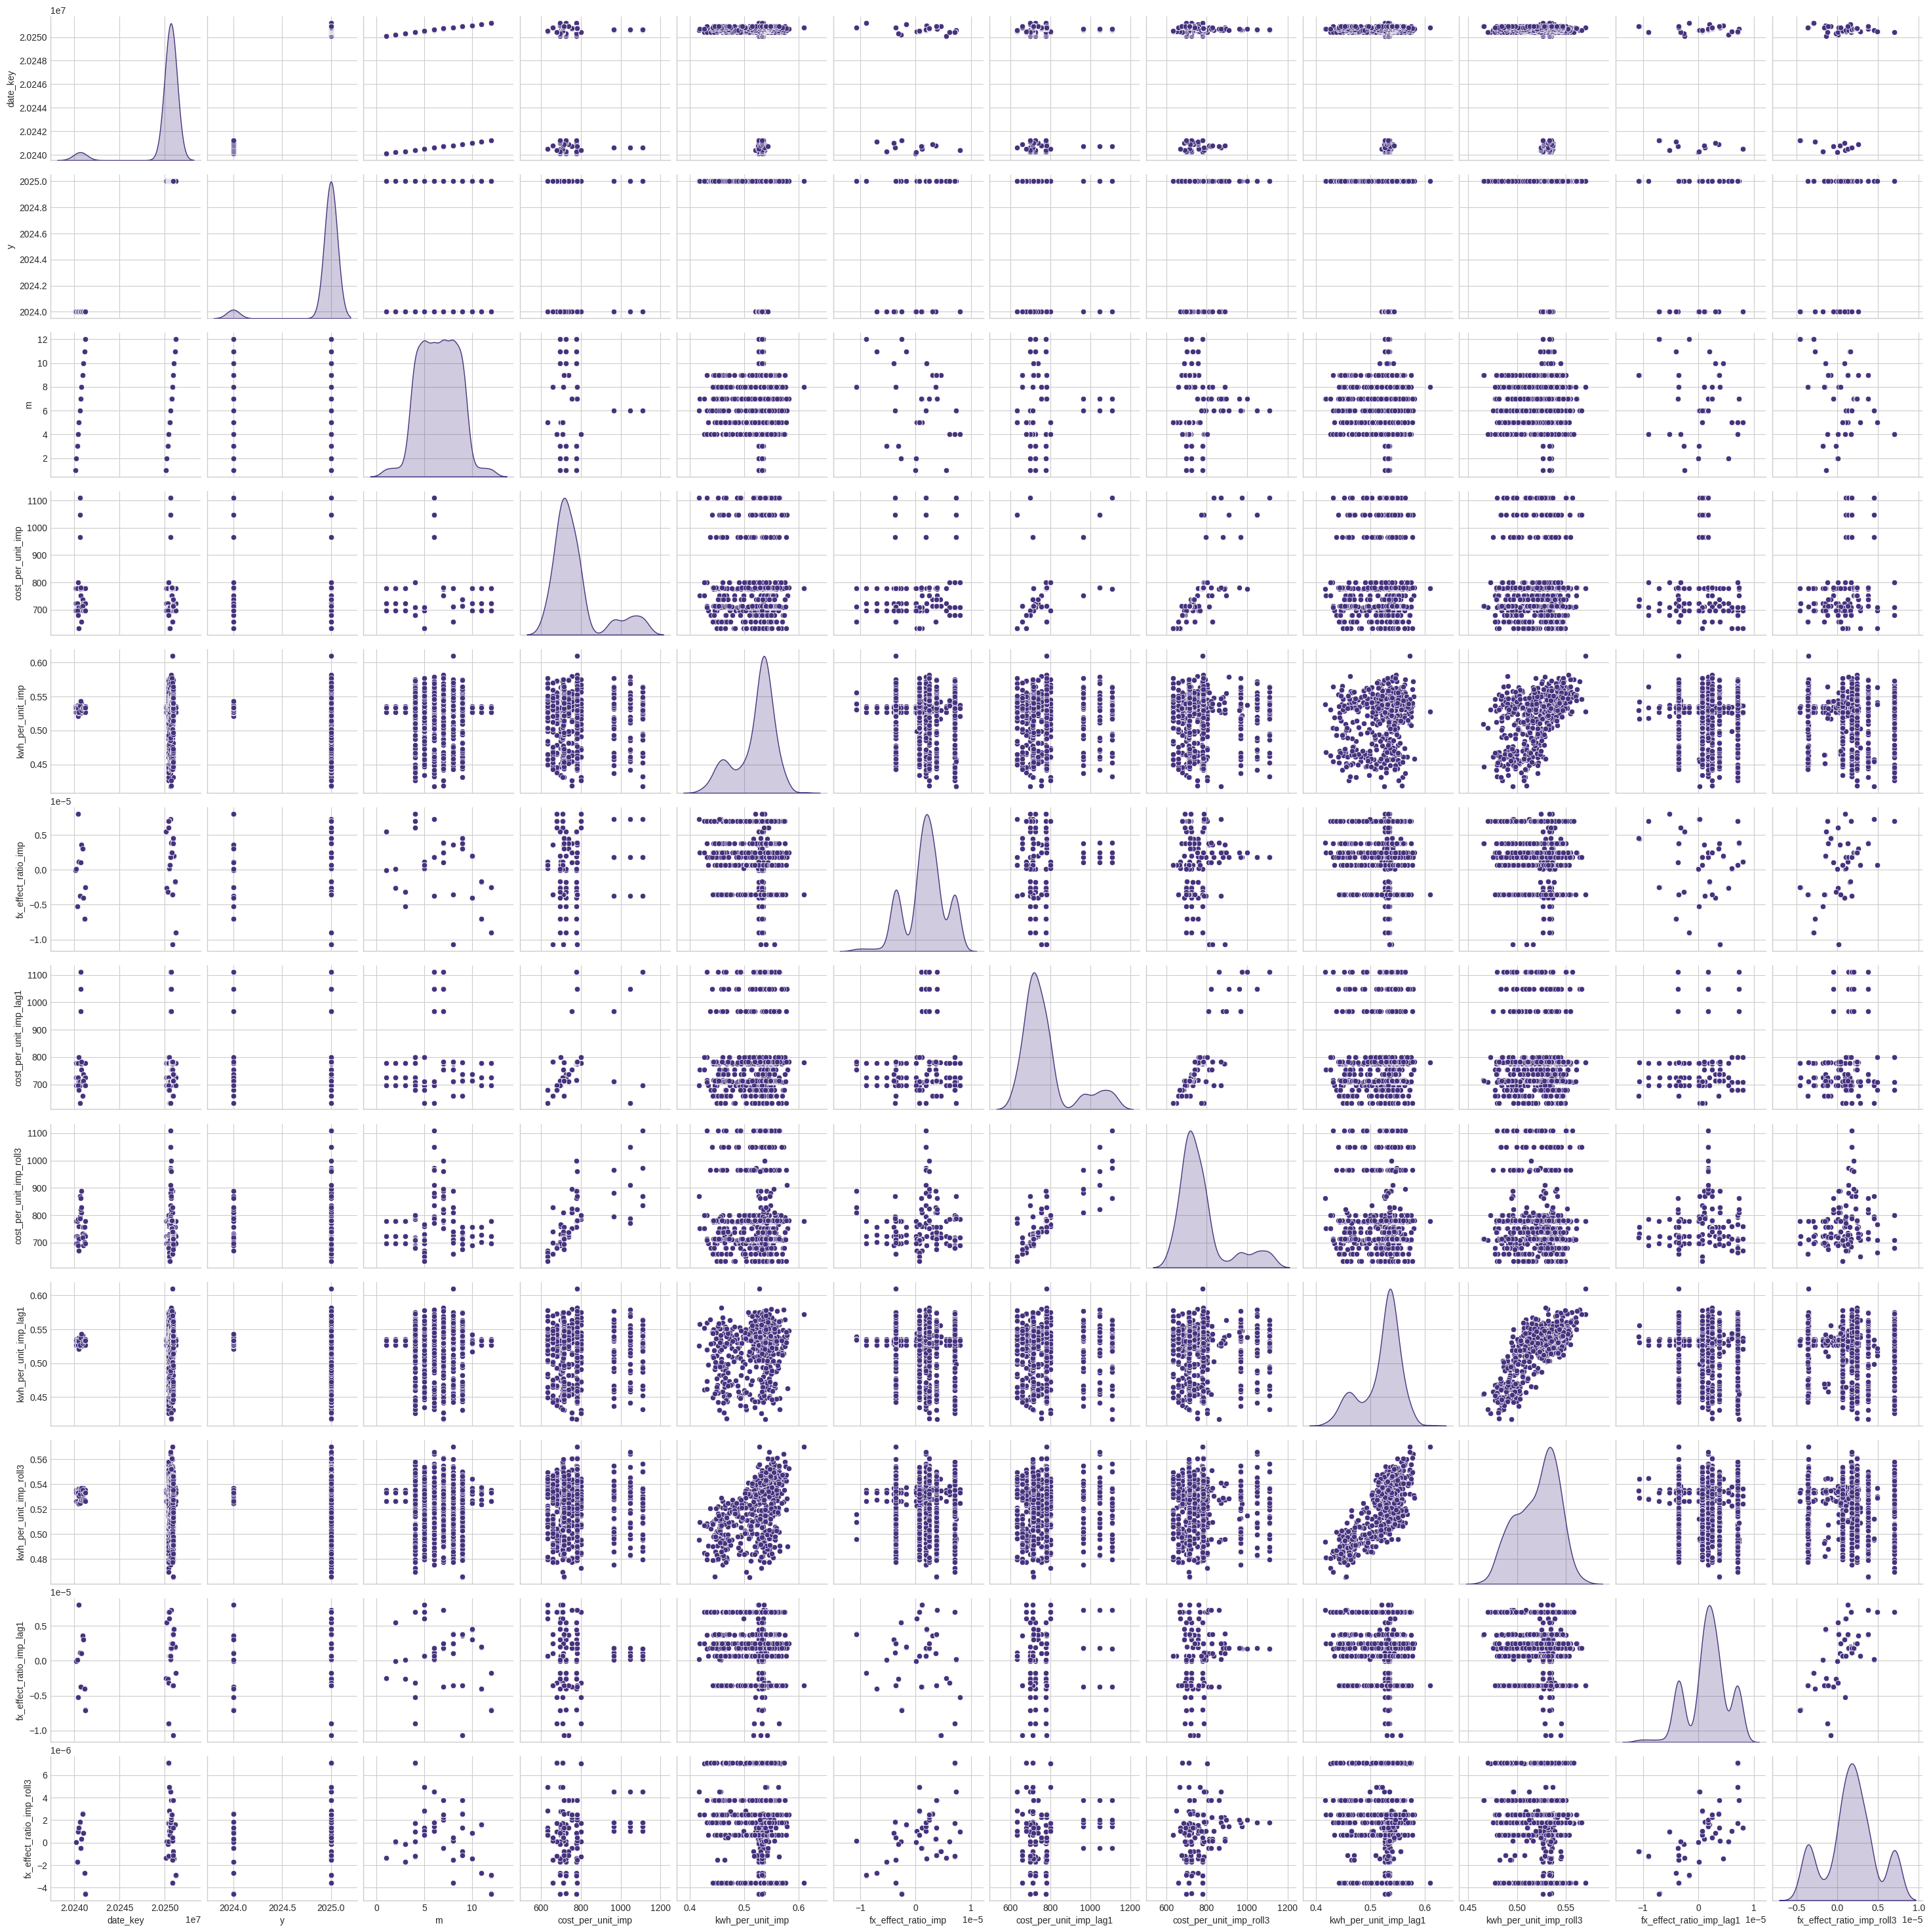

In [26]:
sns.pairplot(model_df, diag_kind='kde');

In [27]:
print(display(model_df.cost_per_unit_imp.skew()))
print('=========================================')
print(display(model_df.cost_per_unit_imp.kurtosis()))

np.float64(1.5892093900279098)

None


np.float64(1.5120712208594793)

None


In [28]:
print(display(model_df.kwh_per_unit_imp.skew()))
print('=========================================')
print(display(model_df.kwh_per_unit_imp.kurtosis()))

np.float64(-0.9166305357911638)

None


np.float64(0.08988021598098817)

None


In [29]:
print(display(model_df.fx_effect_ratio_imp.skew()))
print('=========================================')
print(display(model_df.fx_effect_ratio_imp.kurtosis()))

np.float64(-0.47869313124640417)

None


np.float64(0.23651001689808693)

None


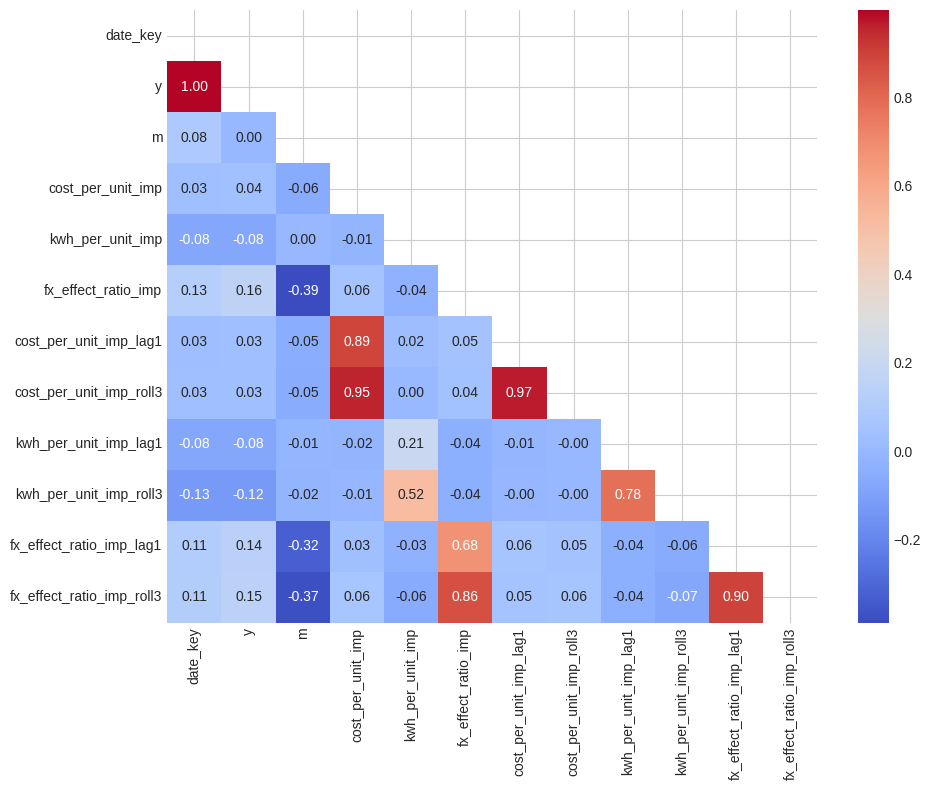

In [30]:
numeric_df = model_df.select_dtypes(include=['float64', 'int64'])

matriz = np.triu(numeric_df.corr())

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(numeric_df.corr(), mask=matriz, annot=True, fmt='.2f', ax=ax, cmap='coolwarm')

plt.tight_layout()
plt.show()

## Exportação do arquivo consolidado

In [31]:
# Caminho base
OUTPUT_PATH = GOLD_DIR

# Nome do arquivo consolidado
file_name = "kpi_consolidated_features.parquet"

# Exporta o dataset final pronto para ML
model_df.to_parquet(OUTPUT_PATH / file_name, index=False)

print(f"Arquivo consolidado salvo em: {OUTPUT_PATH / file_name}")

Arquivo consolidado salvo em: /home/rusch/Área de trabalho/Projeto_Whirpool/Data_Science_Projects/eda/data/gold/kpi_consolidated_features.parquet


## 6️⃣ Conclusões e próximos passos
📊 **Resumo:**
- Avaliamos as séries temporais dos principais KPIs pós-ETL.
- Detectamos possíveis outliers e verificamos correlações entre custos, energia e FX.
- Este notebook complementa o dashboard, oferecendo uma análise quantitativa detalhada.

🚀 **Próximo passo:** consolidar insights e versionar o pipeline completo no GitHub.